In [13]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import numpy as np

In [14]:
hotel = pd.read_csv("/content/tripadvisor_hotel_reviews.csv")
hotel

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [15]:
def map_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

In [16]:
hotel["Sentiment"] = hotel["Rating"].apply(map_sentiment)
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
hotel["label"] = hotel["Sentiment"].map(label2id)

In [17]:
hotel.head(3)

,Review,Rating,Sentiment,label
0,nice hotel expensive parking got good deal sta...,4,positive,2
1,ok nothing special charge diamond member hilto...,2,negative,0
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,1


In [18]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    hotel["Review"].tolist(), hotel["label"].tolist(), test_size=0.2, random_state=42
)

### *Tokenization*

In [19]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

### *TensorFlow datasets*

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(10000).batch(16)

In [22]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

## *Load model*

In [23]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [25]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Epoch 1/3
1025/1025 [==============================] - 494s 462ms/step - loss: 0.3822 - accuracy: 0.8573 - val_loss: 0.3096 - val_accuracy: 0.8841
Epoch 2/3
1025/1025 [==============================] - 464s 453ms/step - loss: 0.2670 - accuracy: 0.8954 - val_loss: 0.3106 - val_accuracy: 0.8800
Epoch 3/3
1025/1025 [==============================] - 464s 453ms/step - loss: 0.1881 - accuracy: 0.9277 - val_loss: 0.3980 - val_accuracy: 0.8727


### *Evaluate*

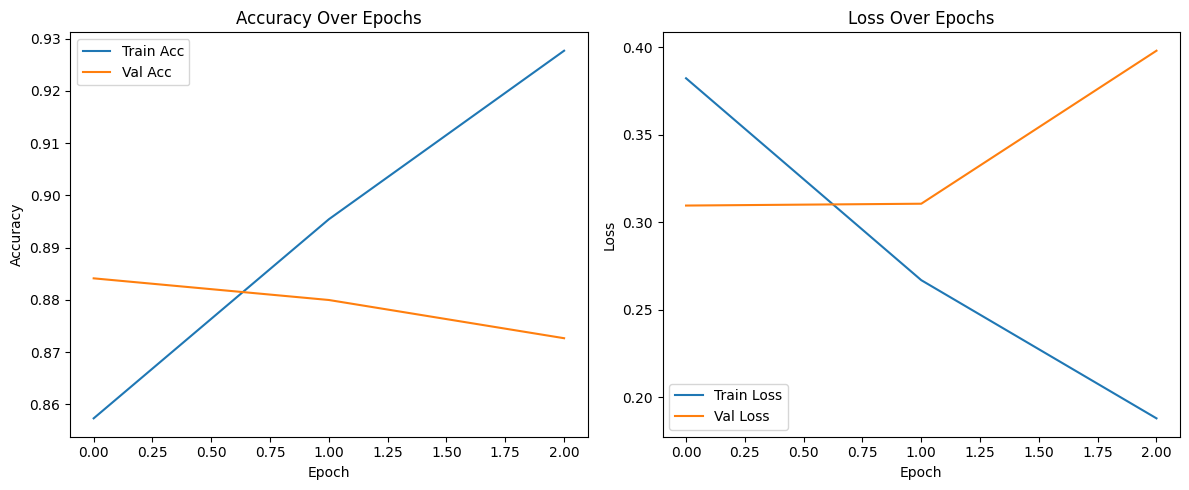

In [26]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
loss, accuracy = model.evaluate(val_dataset)
print(f"\n Validation Accuracy: {accuracy:.4f}")

257/257 [==============================] - 38s 146ms/step - loss: 0.3980 - accuracy: 0.8727

✅ Validation Accuracy: 0.8727


In [33]:
print("\n🔍 Generating Predictions and Confusion Matrix...")


🔍 Generating Predictions and Confusion Matrix...


### *Predict logits*

In [34]:
y_pred_logits = model.predict(val_dataset).logits
y_pred = tf.math.argmax(y_pred_logits, axis=1).numpy()
y_true = np.array(val_labels)

257/257 [==============================] - 36s 140ms/step


### *Confusion matrix*

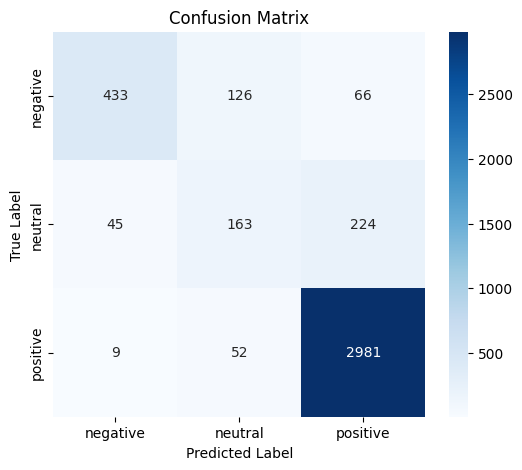

In [30]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label2id.keys()),
            yticklabels=list(label2id.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [35]:
# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label2id.keys()))


📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.69      0.78       625
     neutral       0.48      0.38      0.42       432
    positive       0.91      0.98      0.94      3042

    accuracy                           0.87      4099
   macro avg       0.76      0.68      0.71      4099
weighted avg       0.86      0.87      0.86      4099



### *Show random predictions*

In [36]:
print("\n🎯 Sample Predictions:")
for i in np.random.choice(len(val_texts), size=5, replace=False):
    text = val_texts[i]
    true_label = id2label[val_labels[i]]
    pred_label = id2label[y_pred[i]]
    print(f"\n📝 Review: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"✅ True Sentiment: {true_label}")
    print(f"🤖 Predicted Sentiment: {pred_label}")


🎯 Sample Predictions:

📝 Review: not worth money writing review bedroom hotel w. 6 30 minutes room neigbour talking phone hear says, no soundproofing swear room pretty annoying.the hotel w nice location great staff ok definitely not ...
✅ True Sentiment: negative
🤖 Predicted Sentiment: neutral

📝 Review: read reviews booking friend wanted short vacation beach location travel agent told apple square deal thought sounded great, did not know stay arrived airport checked apple brochure princess looked fin...
✅ True Sentiment: negative
🤖 Predicted Sentiment: negative

📝 Review: nothing bad 10 arrived amsterdam 50th, hotel booked on-line using previous references trip advisor, hotel 5 minutes centraal station ready arrived, work canal weekdays starts 8.00am pile driving noisy...
✅ True Sentiment: neutral
🤖 Predicted Sentiment: positive

📝 Review: loved, ca n't say hotel, arrived requested romantic room view effiel tower got, 5th floor 2 balconies great view, 1/2 rooms hotel great view balco